In [10]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [11]:
# 1) Imports & Seed
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score, cohen_kappa_score

# PyG imports
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

In [12]:
# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
# 2) Load & Normalize
mat = sio.loadmat('/content/drive/MyDrive/Indian_pines_corrected.mat')
img = mat['indian_pines_corrected'].astype(np.float32)   # H×W×B
gt  = sio.loadmat('/content/drive/MyDrive/Indian_pines_gt.mat')['indian_pines_gt']
H, W, B = img.shape

# Min-Max normalize per band
img_flat = img.reshape(-1, B)
img_norm = MinMaxScaler().fit_transform(img_flat).reshape(H, W, B)

In [14]:
# 3) Patch Extraction with augmentation
patch_size = 7  # Increased patch size for better spatial context
pad = patch_size // 2
img_pad = np.pad(img_norm, ((pad,pad),(pad,pad),(0,0)), mode='reflect')

patches, labels = [], []
for i in range(H):
    for j in range(W):
        lbl = int(gt[i,j])
        if lbl==0: continue
        patch = img_pad[i:i+patch_size, j:j+patch_size, :]
        patches.append(patch)
        labels.append(lbl-1)  # zero-index

patches = np.stack(patches)   # N_patches × patch_size × patch_size × B
labels  = np.array(labels)    # N_patches

In [15]:
# 4) Train/Test Split (class-balanced with more training samples)
class_dist = {1:50,2:50,3:50,4:50,5:50,6:50,7:30,8:50,9:20,
              10:50,11:50,12:50,13:50,14:50,15:50,16:50}
train_idx, test_idx = [], []
for cls in range(16):
    idxs = np.where(labels==cls)[0]
    np.random.shuffle(idxs)
    n = min(class_dist[cls+1], len(idxs)-5)  # Ensure at least 5 samples per class for testing
    train_idx += idxs[:n].tolist()
    test_idx  += idxs[n:].tolist()

In [16]:
# 5) Graph Construction fn
def make_edge_index(patch_size):
    # connect each pixel to its 8-neighbors in the patch grid (including diagonals)
    coords = [(r,c) for r in range(patch_size) for c in range(patch_size)]
    N = patch_size*patch_size
    edges = []
    for idx,(r,c) in enumerate(coords):
        for dr,dc in [(1,0),(-1,0),(0,1),(0,-1),(1,1),(-1,-1),(1,-1),(-1,1)]:
            nr, nc = r+dr, c+dc
            if 0<=nr<patch_size and 0<=nc<patch_size:
                n_idx = nr*patch_size + nc
                edges.append([idx, n_idx])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

edge_index = make_edge_index(patch_size)  # reused for all graphs

In [17]:
# 6) Build PyG Datasets
def build_dataset(idxs):
    data_list = []
    for i in idxs:
        x = torch.tensor(patches[i].reshape(-1, B), dtype=torch.float)  # nodes × features
        y = torch.tensor([labels[i]], dtype=torch.long)
        data_list.append(Data(x=x, edge_index=edge_index, y=y))
    return data_list

train_data = build_dataset(train_idx)
test_data  = build_dataset(test_idx)

# Data loaders with appropriate batch sizes
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [18]:
# 7) Define Enhanced SSGRN
class SSGRN(nn.Module):
    def __init__(self, in_feats, hidden_dim, num_classes, dropout_rate=0.3):
        super().__init__()
        # Spectral branch: deeper MLP with residual connections
        self.spec_lin1 = nn.Linear(in_feats, hidden_dim)
        self.spec_bn1 = nn.BatchNorm1d(hidden_dim)
        self.spec_lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.spec_bn2 = nn.BatchNorm1d(hidden_dim)
        self.spec_lin3 = nn.Linear(hidden_dim, hidden_dim)
        self.spec_bn3 = nn.BatchNorm1d(hidden_dim)

        # Spatial branch: enhanced GCN with attention
        self.gcn1 = GCNConv(in_feats, hidden_dim)
        self.gcn_bn1 = nn.BatchNorm1d(hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.gcn_bn2 = nn.BatchNorm1d(hidden_dim)
        self.gcn3 = GCNConv(hidden_dim, hidden_dim)
        self.gcn_bn3 = nn.BatchNorm1d(hidden_dim)

        # Fusion layer
        self.fuse_lin = nn.Linear(hidden_dim*2, hidden_dim)
        self.fuse_bn = nn.BatchNorm1d(hidden_dim)

        # Classifier
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Spectral encoding with residuals
        s1 = F.relu(self.spec_bn1(self.spec_lin1(x)))
        s2 = F.relu(self.spec_bn2(self.spec_lin2(s1)))
        s3 = F.relu(self.spec_bn3(self.spec_lin3(s2))) + s1  # Residual connection

        # Spatial encoding with residuals
        g1 = F.relu(self.gcn_bn1(self.gcn1(x, edge_index)))
        g2 = F.relu(self.gcn_bn2(self.gcn2(g1, edge_index)))
        g3 = F.relu(self.gcn_bn3(self.gcn3(g2, edge_index))) + g1  # Residual connection

        # Fuse spectral and spatial features
        h = torch.cat([s3, g3], dim=1)
        h = F.relu(self.fuse_bn(self.fuse_lin(h)))
        h = self.dropout(h)

        # Global pooling per graph
        hg = global_mean_pool(h, batch)   # [num_graphs × hidden]

        # Classification
        return self.classifier(hg)

In [19]:
# 8) Train & Eval with Learning Rate Scheduler and Improved Early Stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SSGRN(in_feats=B, hidden_dim=128, num_classes=16, dropout_rate=0.3).to(device)

# Use Adam with weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5, verbose=True
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# Weighted loss for class imbalance
class_weights = torch.ones(16, device=device)
for cls in range(16):
    n_samples = (labels == cls).sum()
    class_weights[cls] = 1.0 / (n_samples + 1e-6)
class_weights = class_weights / class_weights.sum() * 16
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [21]:
# Early stopping setup
best_val_acc = 0
patience = 20
counter = 0
best_epoch = 0

In [22]:
# Tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [23]:
# Training loop
max_epochs = 200
for epoch in range(1, max_epochs + 1):
    # Training phase
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs
        _, preds = torch.max(out, 1)
        correct += (preds == batch.y).sum().item()
        total += batch.num_graphs

    train_loss = total_loss / len(train_data)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item() * batch.num_graphs

            _, preds = torch.max(out, 1)
            correct += (preds == batch.y).sum().item()
            total += batch.num_graphs

    val_loss = val_loss / len(test_data)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Early stopping based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_ssgrn_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}. Best epoch: {best_epoch} with accuracy: {best_val_acc:.4f}')
            break

    # Print progress
    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

Epoch 001 | Train Loss: 1.3266 | Train Acc: 0.3265 | Val Loss: 3.3414 | Val Acc: 0.0058
Epoch 010 | Train Loss: 0.0941 | Train Acc: 0.8724 | Val Loss: 1.4256 | Val Acc: 0.4705
Epoch 020 | Train Loss: 0.0506 | Train Acc: 0.9246 | Val Loss: 2.0106 | Val Acc: 0.5007
Epoch 030 | Train Loss: 0.0273 | Train Acc: 0.9602 | Val Loss: 1.2880 | Val Acc: 0.6157
Epoch 040 | Train Loss: 0.0185 | Train Acc: 0.9657 | Val Loss: 1.4724 | Val Acc: 0.5776
Epoch 050 | Train Loss: 0.0121 | Train Acc: 0.9808 | Val Loss: 0.2409 | Val Acc: 0.9172
Epoch 060 | Train Loss: 0.0132 | Train Acc: 0.9753 | Val Loss: 0.2223 | Val Acc: 0.9274
Epoch 070 | Train Loss: 0.0098 | Train Acc: 0.9890 | Val Loss: 0.2197 | Val Acc: 0.9300
Epoch 080 | Train Loss: 0.0090 | Train Acc: 0.9877 | Val Loss: 0.2076 | Val Acc: 0.9366
Early stopping at epoch 81. Best epoch: 61 with accuracy: 0.9371


In [24]:
# Load best model
model.load_state_dict(torch.load('best_ssgrn_model.pth'))

<All keys matched successfully>

In [25]:
# Final evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        preds = out.argmax(dim=1).cpu().tolist()
        y_true += batch.y.cpu().tolist()
        y_pred += preds

In [26]:
# Calculate metrics
OA = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)
class_acc = [conf_mat[i,i] / conf_mat[i,:].sum() for i in range(16)]
AA = np.mean(class_acc)
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

In [27]:
print('\nFinal Results:')
print(f'Overall Accuracy (OA): {OA:.4f}')
print(f'Average Accuracy (AA): {AA:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Cohen\'s Kappa: {kappa:.4f}')

# Print individual class accuracies
print('\nClass-wise Accuracies:')
for i in range(16):
    print(f'Class {i+1}: {class_acc[i]:.4f}')

# Print detailed classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, digits=4))


Final Results:
Overall Accuracy (OA): 0.9371
Average Accuracy (AA): 0.9733
F1 Score: 0.9373
Cohen's Kappa: 0.9281

Class-wise Accuracies:
Class 1: 1.0000
Class 2: 0.9521
Class 3: 0.9038
Class 4: 0.9840
Class 5: 0.9931
Class 6: 0.9941
Class 7: 1.0000
Class 8: 1.0000
Class 9: 1.0000
Class 10: 0.9566
Class 11: 0.8462
Class 12: 0.9779
Class 13: 1.0000
Class 14: 0.9835
Class 15: 0.9821
Class 16: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0     0.6250    1.0000    0.7692         5
           1     0.9111    0.9521    0.9312      1378
           2     0.9819    0.9038    0.9413       780
           3     0.8402    0.9840    0.9064       187
           4     0.9751    0.9931    0.9840       433
           5     0.9797    0.9941    0.9869       680
           6     0.8333    1.0000    0.9091         5
           7     1.0000    1.0000    1.0000       428
           8     0.5556    1.0000    0.7143         5
           9     0.8228    0.9566

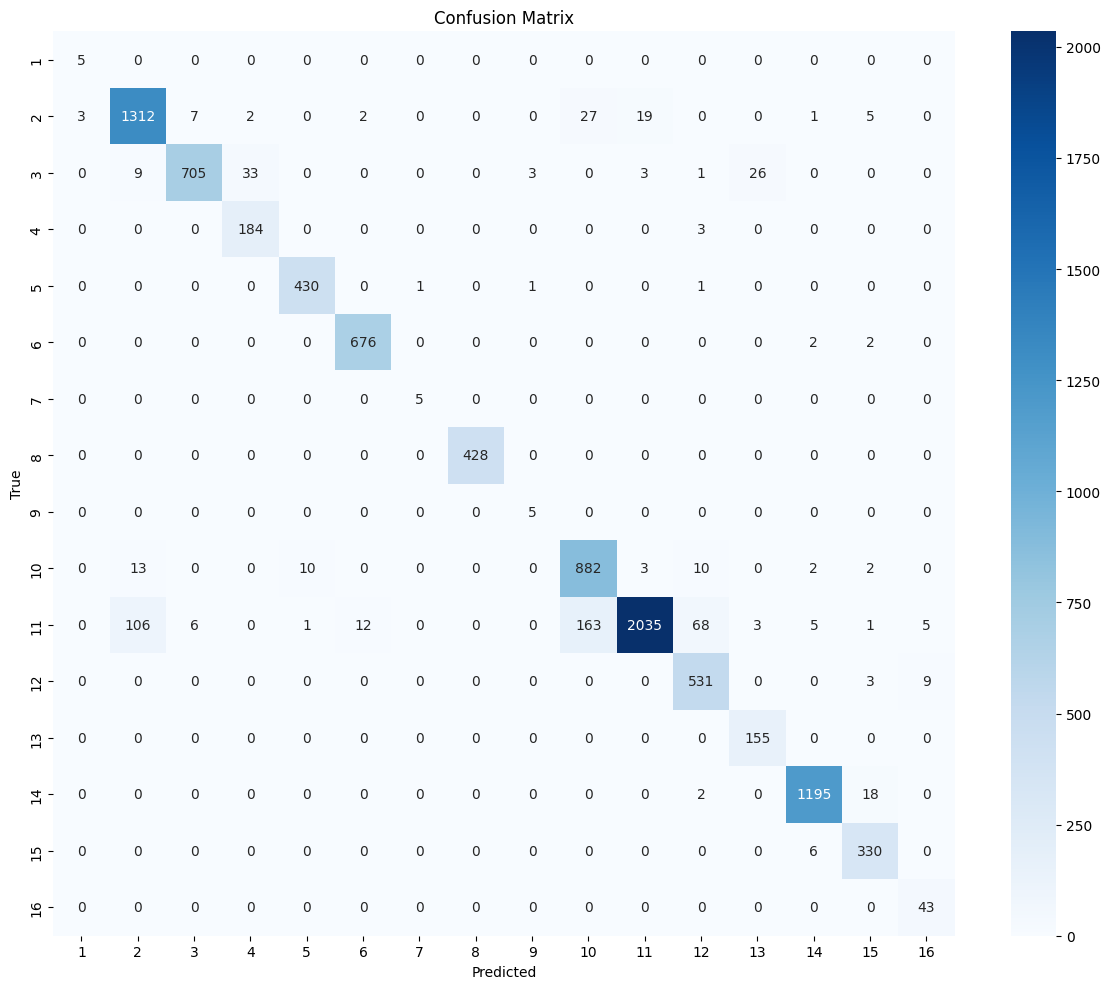

In [28]:
# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(1, 17), yticklabels=np.arange(1, 17))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('ssgrn_confusion_matrix.png')
plt.show()

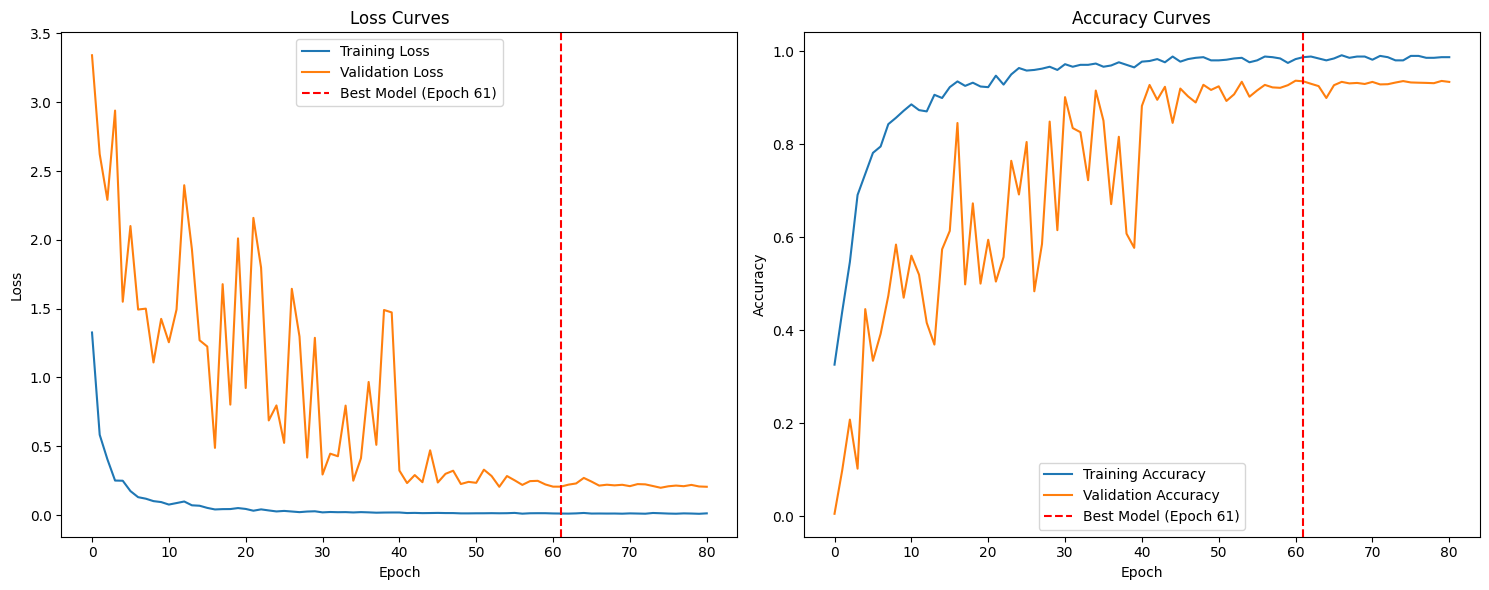

In [29]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.savefig('ssgrn_training_curves.png')
plt.show()